## Data analysis

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data_default.csv', header=0)

df.head()

gpu          gemm input mode     m     n     k  \
NVIDIA_GH200_120GB D  normal01   fp64_int8_3     N    N  1024  1024  1024   
                   D  normal01   fp64_int8_9     N    N  1024  1024  1024   
                   D  normal01  fp64_int8_18     N    N  1024  1024  1024   
                   D  normal01         dgemm     N    N  1024  1024  1024   
                   D  normal01   fp64_int8_3     N    N  2048  2048  2048   

                          residual  max_relative  throughput_in_tflops  
NVIDIA_GH200_120GB D  2.401237e-05  2.757648e+01             15.468640  
                   D  2.275485e-16  5.395420e-12              3.109284  
                   D  2.275303e-16  1.286471e-15              0.876498  
                   D  1.066552e-15  9.625805e-10             52.867900  
                   D  2.717785e-05  3.946706e+01             37.601840

In [13]:
df['slices'] = df['gemm'].str.extract(r'fp64_int8_(\d+)').astype(float)
df.loc[df['gemm'] == 'dgemm', 'slices'] = 0

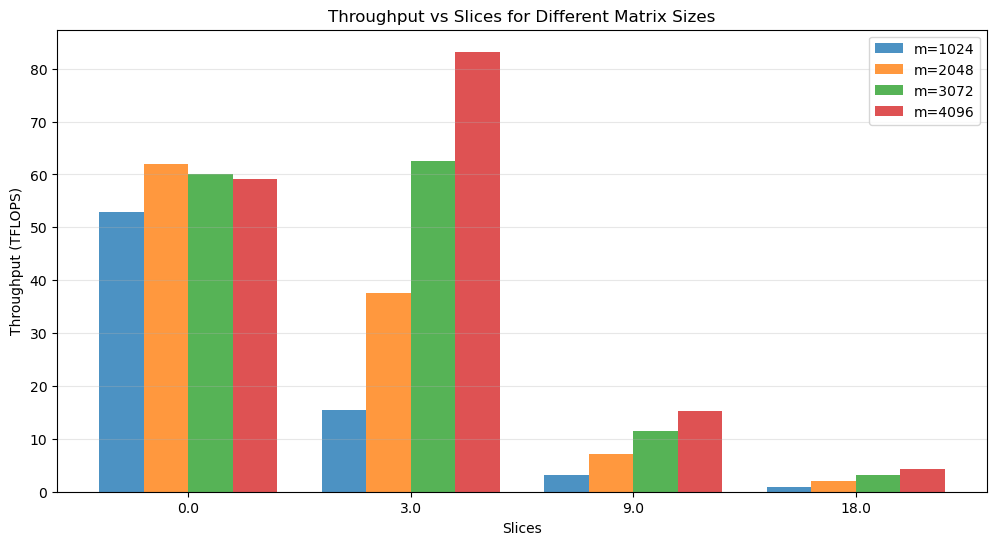

In [14]:
# Get unique matrix sizes (m values)
m_values = df['m'].unique()

# Get unique slice values (excluding NaN)
slice_values = df['slices'].dropna().unique()
slice_values = sorted(slice_values)

plt.figure(figsize=(12, 6))

width = 0.8 / len(m_values)  # Adjust width based on number of m values
x_pos = range(len(slice_values))

# Plot a bar for each m value
for i, m_val in enumerate(m_values):
    df_m = df[df['m'] == m_val].dropna(subset=['slices'])
    
    # Sort by slices to match x_pos
    df_m = df_m.sort_values('slices')
    
    offset = (i - len(m_values)/2 + 0.5) * width
    plt.bar([p + offset for p in x_pos], 
            df_m['throughput_in_tflops'], 
            width, 
            label=f'm={m_val}', 
            alpha=0.8)

plt.xlabel('Slices')
plt.ylabel('Throughput (TFLOPS)')
plt.title('Throughput vs Slices for Different Matrix Sizes')
plt.xticks(x_pos, slice_values)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

------------------

## GB10 results

In [15]:
df_gb10 = pd.read_csv('data_gb10.csv', header=0)

In [16]:
df_gb10.head()

,gpu,input,slicing,m,residual,max_relative,throughput_in_tflops
0,NVIDIA_GB10,default,3,1024,2.401237e-05,2.757648e+01,2.825389
1,NVIDIA_GB10,default,9,1024,2.275485e-16,5.395420e-12,0.466159
2,NVIDIA_GB10,default,18,1024,2.275303e-16,1.286471e-15,0.153885
3,NVIDIA_GB10,default,dgemm,1024,1.066552e-15,9.625805e-10,0.412760
4,NVIDIA_GB10,default,3,2048,2.717785e-05,3.946706e+01,3.161896


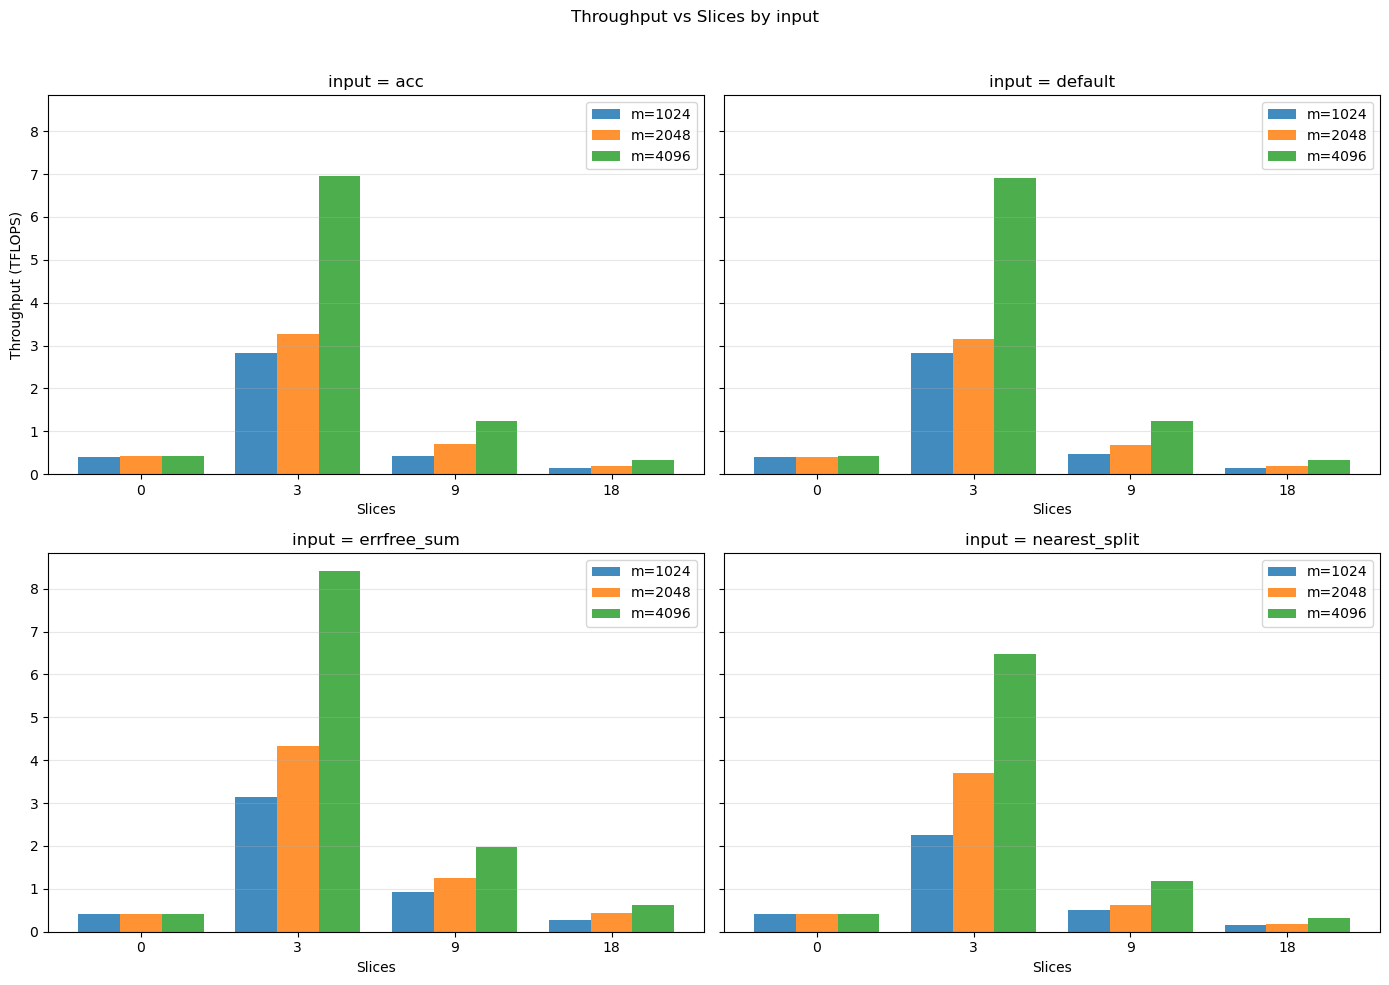

In [18]:
# Plot throughput vs slices for each "input" value in df_gb10 (4 subplots)
# assumes pandas and matplotlib.pyplot (as plt) are already imported and df_gb10 exists

# ensure numeric 'slices' column
if 'slices' not in df_gb10.columns:
    df_gb10['slices'] = df_gb10['slicing'].astype(str).str.extract(r'(\d+)').astype(float)
    df_gb10.loc[df_gb10['slicing'].astype(str).str.contains('dgemm', na=False), 'slices'] = 0.0

inputs = sorted(df_gb10['input'].unique())
m_values = sorted(df_gb10['m'].unique())
slice_values = sorted(df_gb10['slices'].dropna().unique())

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
axes = axes.flatten()

width = 0.8 / max(1, len(m_values))
x_pos = list(range(len(slice_values)))

for ax, inp in zip(axes, inputs):
    df_in = df_gb10[df_gb10['input'] == inp]
    for i, m_val in enumerate(m_values):
        df_m = df_in[df_in['m'] == m_val].dropna(subset=['slices']).sort_values('slices')
        if df_m.empty:
            continue
        offset = (i - len(m_values)/2 + 0.5) * width
        ax.bar([p + offset for p in x_pos],
               df_m['throughput_in_tflops'],
               width,
               label=f'm={m_val}',
               alpha=0.85)
    ax.set_title(f'input = {inp}')
    ax.set_xlabel('Slices')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([int(s) if s == int(s) else s for s in slice_values])
    ax.grid(axis='y', alpha=0.3)
    ax.legend()

axes[0].set_ylabel('Throughput (TFLOPS)')
fig.suptitle('Throughput vs Slices by input')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Adding mysterious "acc" test for reference

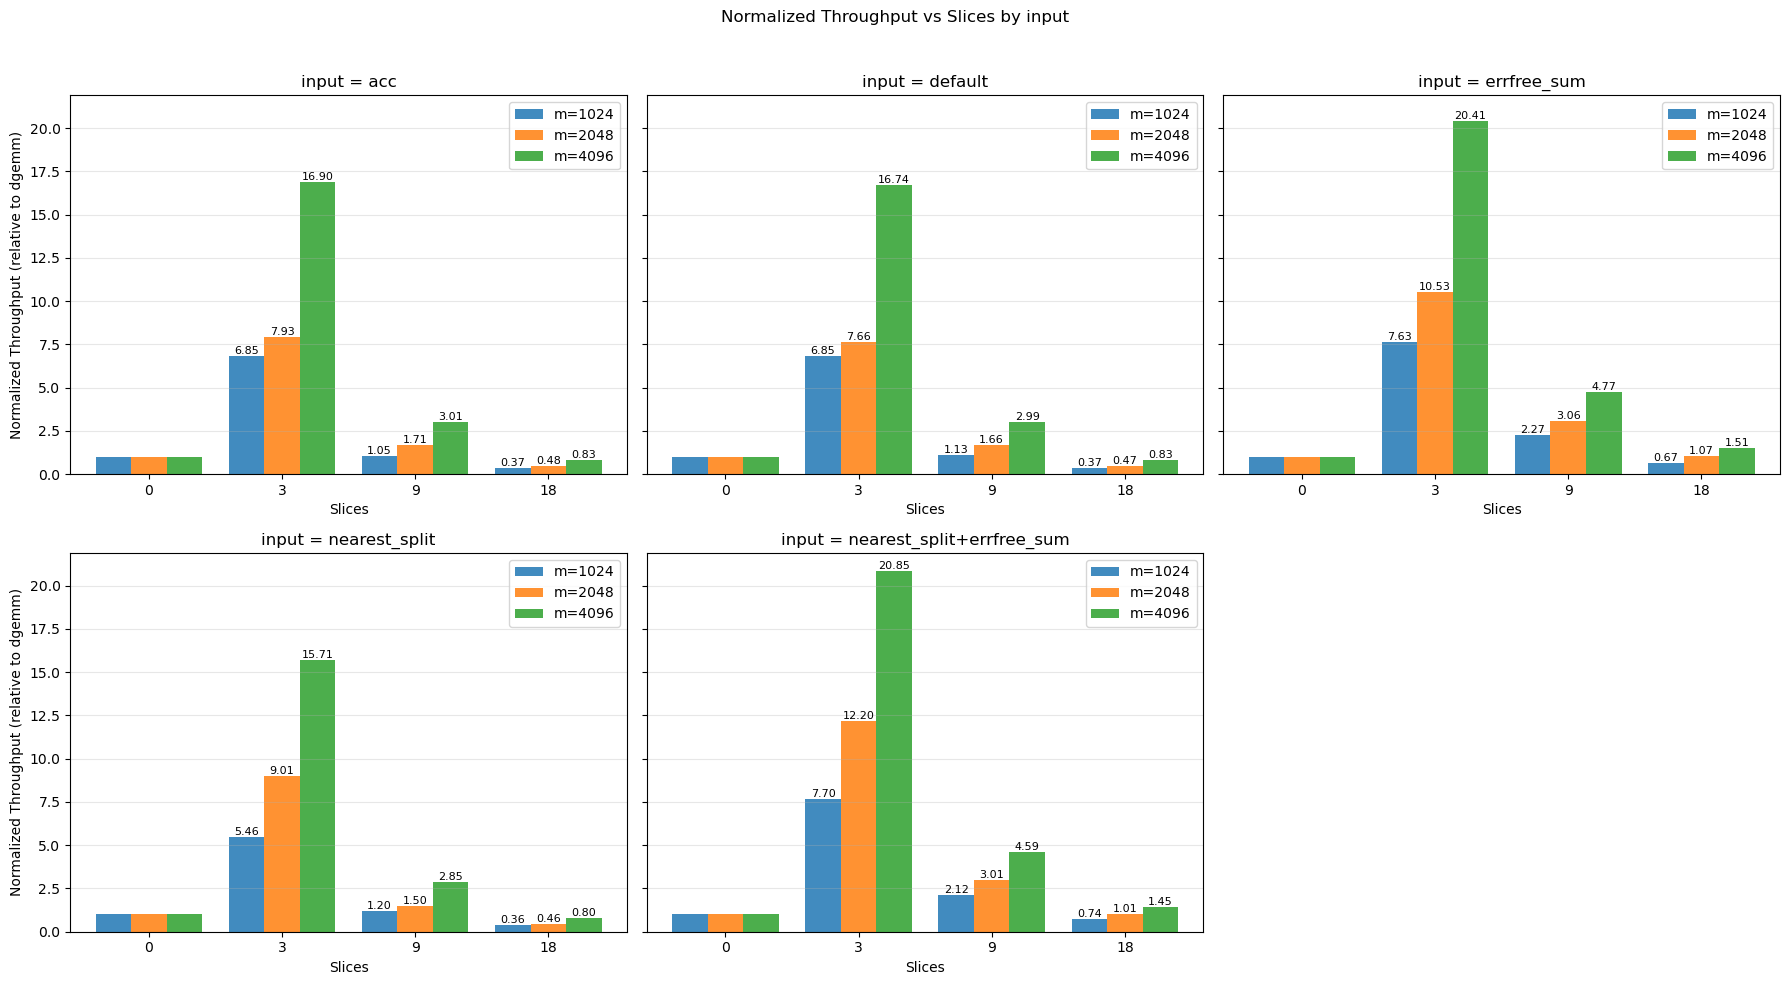

In [21]:
# Add a fifth subplot for 'acc' input type
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
axes = axes.flatten()

# Update inputs to include 'acc'
inputs = sorted(df_gb10['input'].unique())

width = 0.8 / max(1, len(m_values))
x_pos = list(range(len(slice_values)))

for ax, inp in zip(axes[:len(inputs)], inputs):
    df_in = df_gb10[df_gb10['input'] == inp]
    
    # Get dgemm throughput for this input as baseline
    dgemm_baseline_val = df_in[df_in['slices'] == 0.0]['throughput_in_tflops'].iloc[0]
    
    for i, m_val in enumerate(m_values):
        df_m = df_in[df_in['m'] == m_val].dropna(subset=['slices']).sort_values('slices')
        if df_m.empty:
            continue
        
        # Normalize throughput by dgemm baseline
        normalized_throughput = df_m['throughput_in_tflops'] / dgemm_baseline_val
        
        offset = (i - len(m_values)/2 + 0.5) * width
        bars = ax.bar([p + offset for p in x_pos],
               normalized_throughput,
               width,
               label=f'm={m_val}',
               alpha=0.85)
        
        # Add value labels above bars (except for slices = 0)
        for j, (bar, slice_val) in enumerate(zip(bars, df_m['slices'].values)):
            if slice_val != 0.0:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.2f}',
                        ha='center', va='bottom', fontsize=8)
    
    ax.set_title(f'input = {inp}')
    ax.set_xlabel('Slices')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([int(s) if s == int(s) else s for s in slice_values])
    ax.grid(axis='y', alpha=0.3)
    ax.legend()

# Hide the last subplot if there are only 5 inputs
if len(inputs) < 6:
    axes[-1].set_visible(False)

axes[0].set_ylabel('Normalized Throughput (relative to dgemm)')
axes[3].set_ylabel('Normalized Throughput (relative to dgemm)')
fig.suptitle('Normalized Throughput vs Slices by input')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()